In [1]:
import sys
sys.path.append('/home/rustem/projs/strategies')

import pandas as pd
import matplotlib.pyplot as plt
from src.utils import TradingSystem
from tqdm import tqdm

In [2]:
params = {
    'ma_window_width': 5,
    'q_std_rolling_width': 20,
    'sigma_coeff_for_SL': 0.1,
    'q': .8,
    'q_window_width': 20
}
ts = TradingSystem(**params)

df = pd.read_csv(
    '/home/rustem/projs/strategies/data/raw/BTC-USDT.csv',
    index_col=0)[['ts', 'o', 'h', 'l', 'c', 'vol']].sort_values(by='ts')

rows_list = []
history = 43
indices = range(0, df.shape[0] - history)
for i in tqdm(indices, total=len(indices)):
    data = df.iloc[i:i+history]

    signal = ts.get_signal(data)
    sl = ts.get_stoploss()
    is_reached_sl = ts.reached_sl()
    profit = ts.profit()

    last = data.iloc[-1].copy()
    last['signal'] = signal
    last['sl'] = sl
    last['is_reached_sl'] = is_reached_sl
    last['profit'] = profit
    rows_list.append(last.to_dict())

100%|██████████| 99957/99957 [07:41<00:00, 216.51it/s]


In [3]:
df = pd.DataFrame(rows_list)

In [4]:
class InpOutpPrices:
    def __init__(self):
        self.inp = None
        self.outp = None
        self.side = None
    def __call__(self, row: pd.Series) -> dict:
        if not pd.isna(row['signal']) and row['signal']['action'] == 'open':
            self.side = row['signal']['type']
            self.inp = row['signal']['price']
        if not pd.isna(self.inp) and self.side == 1 and row['o'] <= row['sl']:
            self.outp = row['o']
        elif not pd.isna(self.inp) and self.side == 0 and row['o'] >= row['sl']:
            self.outp = row['o']
        elif not pd.isna(self.inp) and row['is_reached_sl']:
            self.outp = row['sl']
        if not pd.isna(self.inp) and not pd.isna(self.outp):
            side, inp, outp = self.side, round(self.inp, 1), round(self.outp, 1)
            self.side, self.inp, self.outp = None, None, None
            return {'side': side, 'inp': inp, 'outp': outp}
        if not pd.isna(row['signal']) and row['signal']['action'] == 'close':
            if not pd.isna(self.inp): 
                self.outp = row['signal']['price']
                side, inp, outp = self.side, round(self.inp, 1), round(self.outp, 1)
                self.side, self.inp, self.outp = None, None, None
                return {'side': side, 'inp': inp, 'outp': outp}
        return None

In [5]:
get_inp_outp_prices = InpOutpPrices()

In [6]:
df['inp_outp_prices'] = df.apply(lambda x: get_inp_outp_prices(x), axis=1)

In [7]:
df.iloc[:50]

,ts,o,h,l,c,vol,signal,sl,is_reached_sl,profit,inp_outp_prices
0,1.678775e+12,24378.5,24399.8,24373.0,24393.2,3.0,NaN,NaN,NaN,NaN,None
1,1.678775e+12,24389.6,24401.8,24388.0,24388.0,5.0,NaN,NaN,NaN,NaN,None
2,1.678775e+12,24386.0,24396.9,24385.4,24396.8,1.0,NaN,NaN,NaN,NaN,None
3,1.678775e+12,24396.8,24402.0,24396.8,24400.7,1.0,NaN,NaN,NaN,NaN,None
4,1.678776e+12,24400.0,24402.5,24379.7,24381.8,3.0,NaN,NaN,NaN,NaN,None
5,1.678776e+12,24389.7,24393.3,24386.1,24392.9,1.0,NaN,NaN,NaN,NaN,None
6,1.678776e+12,24392.9,24398.2,24385.7,24385.7,0.0,NaN,NaN,NaN,NaN,None
7,1.678776e+12,24386.9,24389.4,24377.1,24387.7,4.0,NaN,NaN,NaN,NaN,None
8,1.678776e+12,24387.7,24387.7,24363.7,24363.7,12.0,"{'type': 1, 'price': 24364.388000000003, 'acti...",24362.450042,False,-0.688000,None
9,1.678776e+12,24361.6,24374.6,24359.6,24374.6,2.0,NaN,24362.450042,True,-1.249958,"{'side': 1, 'inp': 24364.4, 'outp': 24361.6}"


In [8]:
df.to_csv('/home/rustem/projs/strategies/data/inp_outp_prices.csv')

In [9]:
def get_profit(d: dict) -> float:
    if pd.isna(d):
        return 0
    if d['side'] == 0:
        return d['inp'] - d['outp']
    else:
        return d['outp'] - d['inp']

<Axes: >

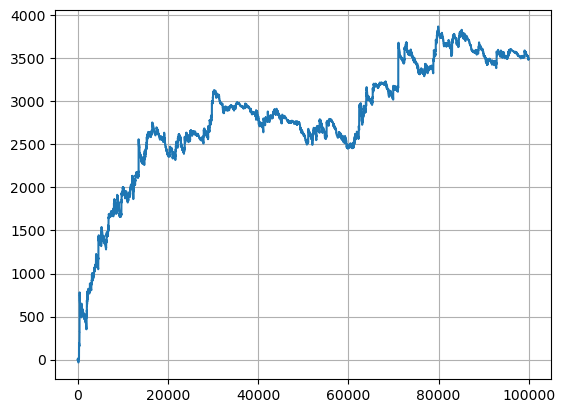

In [10]:
df['inp_outp_prices'].map(lambda x: get_profit(x)).cumsum().plot(grid=True)